In [2]:
%matplotlib inline
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Loading the network, neglect all confidence score less than 700, then restrict to the largest connected component 

In [3]:
G=nx.read_weighted_edgelist("4932.protein.links.v11.0.txt",comments="#",nodetype=str)
# delete those edges with a combined score of <= thershold_score (small confidence)
threshold_score = 700
for edge in G.edges: 
    G.get_edge_data(edge[0],edge[1])
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])
largest_cc = max(nx.connected_components(G),key=len)
G=G.subgraph(largest_cc)

1. Compute the graph laplacian using networkx,laplacian_matrix 
2. Compute all eigenvalues using numpy routine eigh (only for symmetric matrices) for the graph laplacian 

In [4]:
G_Lap = nx.laplacian_matrix(G, nodelist=None, weight=None)
G_Lap = G_Lap.astype(float)
G_Lap_dense = G_Lap.todense()
Eval_Lap_dense = np.linalg.eigh(G_Lap_dense)[0]

1. line 1 to 5 computes the random walk matrix L_r = AD^(-1) 
2. Compute the first/last 1000 eigenvalues using sparse linear algebra scipy packages eigs for the random walk matrix

In [5]:
G_Ad = nx.adjacency_matrix(G, nodelist=None, weight=None)
G_D = G_Ad.sum(axis=1)
G_D = sp.sparse.spdiags(G_D.flatten(), [0], len(G.nodes), len(G.nodes), format='csr')
G_Markov = G_Ad.dot(sp.sparse.linalg.inv(G_D))
G_Markov = G_Markov.astype(float);
EVal_Markov_L, EVec_Markov_L = sp.sparse.linalg.eigs(G_Markov,k=1000,which='LR')

In [26]:
idx = np.argsort(Eval_Lap_dense)
Eval_Lap_dense = Eval_Lap_dense.real[idx]
idx = np.argsort(EVal_Markov_L)
EVal_Markov_L = EVal_Markov_L.real[idx][::-1]

Helper function to print the first k entries of the eigenvalues array 

In [27]:
def plot_ev(L,k):
    plt.plot(L[:k],"-d")
    plt.xlabel("$i$")
    plt.ylabel("$\lambda_i$")
    plt.show()

First/last 1000 eigenvalues for graph laplacian, and random walk matrix. 

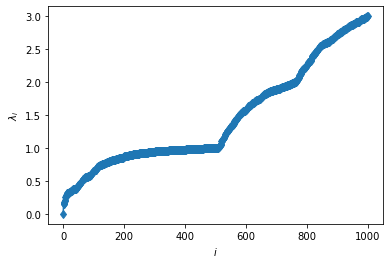

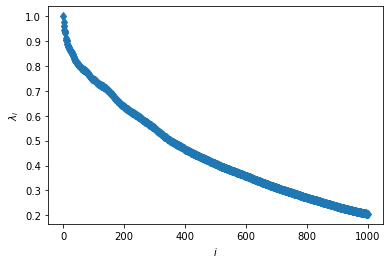

In [28]:
plot_ev(Eval_Lap_dense,1000)
plot_ev(EVal_Markov_L,1000)

First/last 650 eigenvalues for graph laplacian, and random walk matrix. 

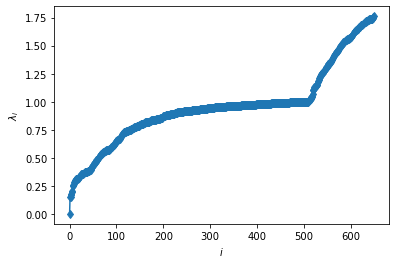

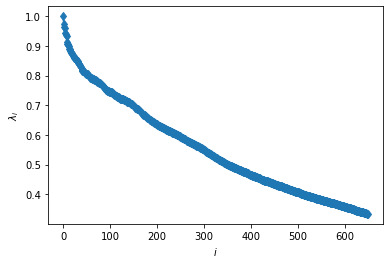

In [29]:
plot_ev(Eval_Lap_dense,650)
plot_ev(EVal_Markov_L,650)

First/last 300 eigenvalues for graph laplacian, and random walk matrix. 

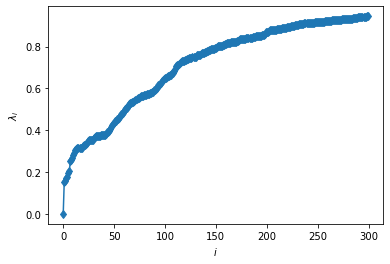

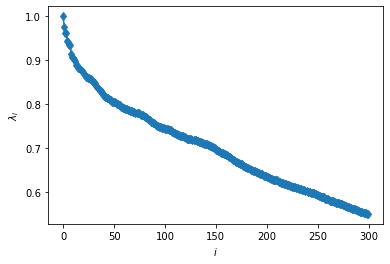

In [30]:
plot_ev(Eval_Lap_dense,300)
plot_ev(EVal_Markov_L,300)

# Comments
First, i want to make some comments on the routines used here to calculate the eigenvalues. 

1. 'np.linalg.eigh' finds all eigenvalues, whereas 'sp.sparse.linalg.eigs' only finds eigenvalues and eigenvectors for specified k. 

2. 'np.linalg.eigh' although is faster than 'sp.sparse.linalg.eigs', it doesn't calculate the eigenvectors, and it can only be used for hermitian/symmetric matrices. So we have to use 'sp.sparse.linalg.eigs' for the random walk matrix (which is not symmetric). 

Next, in terms of community detection, we can run k-means algorithm on the matrix \[v_1,v_2,v_3,...,v_k\] to find the actual communities once we identified what k is. However, just by looking at the graph laplacian, and random walk matrix, they suggest that there isn't actually community structures, becuase: 

1. The spectral gap for the graph laplacian and random walk matrix happened at lambda_2, although this spectral gap for the random walk matrix is small. The differences in lambda_k and lambda_(k+1) in both graphs are generally very small, which indicates strong connections across the network (i.e. less community strucutre).  

2. Looking at the graph for 300 eigenvalues, spectral gap happened at lambda_2. After that, lambda_3, lambda_4,...,lambda_6 are quite close together, then another small spectral gap happened at lambda_7. After that there is no visable spectral gaps. What does this mean for community detection? 

In theory, we should just use the first spectral gap, which says there's just one community. However, i think lambda_3, lambda_4,...,lambda_6 terms have some significance. My guess would be there is one central community (corresponding to lambda_0), and a few smaller communiteis(corresponding to lambda_2,...,lambda_6), the small communities have little connections between each other(small spectral gap between them in the graph), but many connections to the central commmunity(large spectral gap between lambda_1 and lambda_i, 2<=i<=6).But to be honest, i don't think these spectral methods are very good for community detection in protein-protein networks, which has lots of links.  